In [ ]:
#!conda install -y linearmodels

In [12]:
import pandas as pd
import numpy as np
import math
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns
import eikon as ek  # the Eikon Python wrapper package

import cufflinks as cf  # Cufflinks
import configparser as cp
cf.set_config_file(offline=True)  # set the plotting mode to offline


In [2]:
sns.set_style('whitegrid')

In [5]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2023-09')[0]
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 163 entries, 2010-01 to 2023-07
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  163 non-null    float64
 1   SMB     163 non-null    float64
 2   HML     163 non-null    float64
 3   RMW     163 non-null    float64
 4   CMA     163 non-null    float64
 5   RF      163 non-null    float64
dtypes: float64(6)
memory usage: 8.9 KB


/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/795792003.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2023-09')[0]
/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/795792003.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2023-09')[0]


In [173]:
ff_factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-3.36,0.34,0.43,-1.27,0.46,0.00
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01
2010-04,2.00,4.98,2.89,0.69,1.72,0.01
2010-05,-7.89,0.04,-2.44,1.30,-0.21,0.01
...,...,...,...,...,...,...
2023-03,2.51,-6.94,-8.85,2.24,-2.37,0.36
2023-04,0.61,-2.56,-0.04,2.42,2.86,0.35
2023-05,0.35,-0.38,-7.72,-1.81,-7.22,0.36


In [174]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,1.064540,0.002025,-0.152147,0.282025,0.100368,0.059202
std,4.414412,2.594733,3.321943,1.941473,2.132677,0.096852
min,-13.390000,-8.280000,-13.870000,-4.750000,-7.220000,0.000000
25%,-1.400000,-1.800000,-1.880000,-1.105000,-1.285000,0.000000
50%,1.360000,0.140000,-0.420000,0.250000,-0.010000,0.010000
75%,3.465000,1.610000,1.335000,1.300000,1.295000,0.090000
max,13.650000,7.110000,12.750000,7.200000,7.720000,0.450000


In [9]:
ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2023-09')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 163 entries, 2010-01 to 2023-07
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    163 non-null    float64
 1   Mines   163 non-null    float64
 2   Oil     163 non-null    float64
 3   Clths   163 non-null    float64
 4   Durbl   163 non-null    float64
 5   Chems   163 non-null    float64
 6   Cnsum   163 non-null    float64
 7   Cnstr   163 non-null    float64
 8   Steel   163 non-null    float64
 9   FabPr   163 non-null    float64
 10  Machn   163 non-null    float64
 11  Cars    163 non-null    float64
 12  Trans   163 non-null    float64
 13  Utils   163 non-null    float64
 14  Rtail   163 non-null    float64
 15  Finan   163 non-null    float64
 16  Other   163 non-null    float64
dtypes: float64(17)
memory usage: 22.9 KB


/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/2608330356.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2023-09')[0]
/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/2608330356.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2023-09')[0]
/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/2608330356.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object

In [10]:
ff_portfolio_data

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2010-01,-2.15,-12.94,-4.79,-3.63,-3.50,-4.33,-0.47,-2.88,-12.49,-2.91,-7.34,0.36,-2.13,-4.44,-1.29,-0.65,-3.91
2010-02,1.75,12.41,2.32,7.18,9.80,5.77,1.33,5.92,4.48,7.35,7.27,6.60,6.16,-0.42,3.69,2.91,2.57
2010-03,4.96,7.32,3.19,11.23,5.50,7.45,3.24,5.54,11.98,5.32,7.77,8.82,8.98,3.11,6.49,8.30,6.19
2010-04,-1.36,-0.76,4.30,4.91,6.88,2.55,-1.99,10.80,-2.95,3.42,4.82,6.55,2.91,2.84,1.33,1.12,1.41
2010-05,-4.86,-8.01,-10.15,-6.29,-5.43,-10.63,-6.25,-8.12,-7.48,-8.97,-8.08,-7.20,-7.56,-6.30,-5.73,-9.11,-8.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,3.35,1.17,-0.55,3.48,-1.08,-4.91,2.60,-0.09,-8.44,-2.06,6.35,-0.66,-0.58,3.53,4.71,-9.02,6.74
2023-04,2.83,-3.08,2.36,1.94,-0.84,-2.00,4.79,3.69,-7.19,-2.26,-5.42,-13.01,-2.08,1.37,1.99,1.62,1.97
2023-05,-4.82,-6.58,-10.00,-13.86,-6.55,-8.59,-4.20,-3.54,-8.84,-3.94,8.56,11.14,-1.99,-6.18,1.85,-4.13,2.45


In [175]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,0.852270,0.590613,0.831902,1.113190,0.845460,0.906564,1.003497,1.538650,0.901472,1.263988,1.323067,1.771595,1.118834,0.756626,1.147607,1.018344,1.217117
std,3.519269,7.843216,8.169600,6.332214,6.208033,6.205269,3.529249,6.056439,9.217693,5.575148,5.696875,9.027711,5.504497,3.865410,4.754805,5.493501,4.567784
min,-10.410000,-24.510000,-34.790000,-20.320000,-16.880000,-18.770000,-7.850000,-20.420000,-22.340000,-18.120000,-13.760000,-25.950000,-23.120000,-13.070000,-12.470000,-20.310000,-11.610000
25%,-1.375000,-5.140000,-3.340000,-2.170000,-2.730000,-2.030000,-1.460000,-2.440000,-5.085000,-1.845000,-2.090000,-3.620000,-2.090000,-1.545000,-1.150000,-2.350000,-1.345000
50%,0.890000,-0.140000,1.050000,1.070000,1.150000,1.330000,1.160000,2.030000,0.750000,1.490000,2.190000,0.790000,1.210000,1.240000,1.070000,1.780000,1.760000
75%,3.275000,6.800000,4.805000,4.885000,4.415000,4.770000,3.495000,5.570000,5.930000,4.160000,4.845000,5.405000,4.525000,3.255000,3.720000,4.510000,4.130000
max,10.140000,22.030000,32.840000,17.320000,19.100000,18.360000,10.390000,18.010000,23.900000,17.870000,14.740000,39.310000,19.940000,10.370000,18.280000,16.310000,13.900000


In [176]:
cfg = cp.ConfigParser()
cfg.read('../refinitiv.cfg')
ek.set_app_key(cfg['eikon']['app_id'])

In [177]:
dji = ek.get_data('0#.DJI', fields=['TR.CommonName', 'TR.PriceClose',
                                      'TR.Volume', 'TR.TotalReturnYTD'])[0]

In [178]:
dji

,Instrument,Company Common Name,Price Close,Volume,YTD Total Return
0,GS.N,Goldman Sachs Group Inc,323.82,588102,-1.984876
1,NKE.N,Nike Inc,90.17,1801492,-21.849373
2,CSCO.OQ,Cisco Systems Inc,52.71,6358046,14.870536
3,JPM.N,JPMorgan Chase & Co,144.93,2326105,11.645126
4,DIS.N,Walt Disney Co,80.05,2263118,-6.756446
5,INTC.OQ,Intel Corp,33.83,12220554,32.384473
6,DOW.N,Dow Inc,50.48,1100271,5.416689
7,MRK.N,Merck & Co Inc,105.39,1737733,-2.657315
8,CVX.N,Chevron Corp,167.8,1706640,-3.331138
9,AXP.N,American Express Co,151.12,640417,4.831603


In [73]:
const = dji['Instrument'].tolist()
const_limp = [i for i in const if i != '']
const_limp

['GS.N',
 'NKE.N',
 'CSCO.OQ',
 'JPM.N',
 'DIS.N',
 'INTC.OQ',
 'DOW.N',
 'MRK.N',
 'CVX.N',
 'AXP.N',
 'VZ.N',
 'HD.N',
 'WBA.OQ',
 'MCD.N',
 'UNH.N',
 'KO.N',
 'JNJ.N',
 'MSFT.OQ',
 'HON.OQ',
 'CRM.N',
 'PG.N',
 'IBM.N',
 'MMM.N',
 'AAPL.OQ',
 'WMT.N',
 'CAT.N',
 'AMGN.OQ',
 'V.N',
 'TRV.N',
 'BA.N']

In [149]:
from datetime import datetime, timedelta
end = '2023-08-01'
start = '2009-12-01'
print(start, end)

2009-12-01 2023-08-01


In [150]:
df,e = ek.get_data(const_limp[0], ['TR.TotalReturn.date', "TR.ClosePrice", 'TR.TotalReturn'],
{'SDate': start, 'EDate': end, 'Frq': 'M' })
df

,Instrument,Date,Close Price,Total Return
0,GS.N,2009-12-31T00:00:00Z,168.84,-0.48332
1,GS.N,2010-01-29T00:00:00Z,148.72,-11.916607
2,GS.N,2010-02-26T00:00:00Z,156.35,5.365788
3,GS.N,2010-03-31T00:00:00Z,170.63,9.133355
4,GS.N,2010-04-30T00:00:00Z,145.2,-14.903593
...,...,...,...,...
159,GS.N,2023-03-31T00:00:00Z,327.11,-6.306856
160,GS.N,2023-04-28T00:00:00Z,343.44,4.992204
161,GS.N,2023-05-31T00:00:00Z,323.9,-4.961565
162,GS.N,2023-06-30T00:00:00Z,322.54,-0.419883


In [151]:
df,e = ek.get_data(const_limp[0], ['TR.TotalReturn.date', 'TR.TotalReturn'],
{'SDate': start, 'EDate': end, 'Frq': 'M' })
df[const_limp[0]] = np.log((df['Total Return']/100)+1)
weekly_returns = df.drop(['Total Return', 'Instrument'], axis=1).iloc[1:]
weekly_returns.set_index('Date', inplace = True)
weekly_returns

,GS.N
Date,
2010-01-29T00:00:00Z,-0.126886
2010-02-26T00:00:00Z,0.052268
2010-03-31T00:00:00Z,0.0874
2010-04-30T00:00:00Z,-0.161385
2010-05-28T00:00:00Z,-0.004083
...,...
2023-03-31T00:00:00Z,-0.065145
2023-04-28T00:00:00Z,0.048716
2023-05-31T00:00:00Z,-0.050889


In [152]:
meses = weekly_returns.count()[0]
meses

163

In [153]:
for i in const_limp[1:]:
    w, e = ek.get_data(i, ['TR.TotalReturn.date', 'TR.TotalReturn'],
{'SDate': start, 'EDate': end, 'Frq': 'M' })
    w = w[w['Total Return'] != 'NaN']
    w[i] = np.log((w['Total Return'].astype(float)/100)+1)
    w1 = w.drop(['Total Return', 'Instrument'], axis=1).iloc[1:]
    p = round(w1.count()[0])
    print(i, p)
    if p == meses:    
        weekly_returns = weekly_returns.join(w1.set_index('Date'))

NKE.N 163
CSCO.OQ 163
JPM.N 163
DIS.N 163
INTC.OQ 163
DOW.N 52
MRK.N 163
CVX.N 163
AXP.N 163
VZ.N 163
HD.N 163
WBA.OQ 163
MCD.N 163
UNH.N 163
KO.N 163
JNJ.N 163
MSFT.OQ 163
HON.OQ 163
CRM.N 163
PG.N 163
IBM.N 163
MMM.N 163
AAPL.OQ 163
WMT.N 163
CAT.N 163
AMGN.OQ 163
V.N 163
TRV.N 163
BA.N 163


In [154]:
weekly_returns

,GS.N,NKE.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-29T00:00:00Z,-0.126886,-0.035746,-0.063370,-0.066593,-0.087434,-0.050262,0.043904,-0.065344,-0.068919,-0.103993,...,0.022312,-0.067221,-0.026724,-0.093074,-0.000374,-0.080066,0.033206,-0.064097,0.016115,0.112906
2010-02-26T00:00:00Z,0.052268,0.058639,0.079529,0.074933,0.055616,0.064585,-0.034642,0.012023,0.013975,-0.016796,...,0.027719,0.042736,0.002297,0.063034,0.011907,0.088080,-0.032499,0.040348,0.037192,0.048187
2010-03-31T00:00:00Z,0.0874,0.087662,0.067540,0.064136,0.111074,0.080904,0.022914,0.047670,0.081670,0.069753,...,-0.000158,0.008535,0.041785,0.138133,0.033528,0.096823,0.054151,0.065249,0.031461,0.139431
2010-04-30T00:00:00Z,-0.161385,0.032263,0.033620,-0.048601,0.053811,0.025284,-0.063843,0.071373,0.111353,-0.055551,...,-0.010101,0.005831,0.059237,0.105692,-0.035702,0.086281,-0.040989,-0.008827,-0.061158,-0.002482
2010-05-28T00:00:00Z,-0.004083,-0.047618,-0.150443,-0.073061,-0.097430,-0.056674,-0.039289,-0.088340,-0.145623,-0.048583,...,-0.017364,-0.024189,-0.105217,-0.015282,-0.053573,-0.113899,-0.102343,-0.217869,-0.025348,-0.115031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31T00:00:00Z,-0.065145,0.034703,0.076605,-0.095373,0.005207,0.270385,0.008212,0.014757,-0.053355,0.002059,...,0.077803,0.013749,-0.024713,0.112121,0.040861,-0.045739,0.042633,0.024788,-0.071613,0.052575
2023-04-28T00:00:00Z,0.048716,0.032727,-0.093568,0.066881,0.023393,-0.050536,0.081899,0.032679,-0.018411,0.014848,...,0.056642,-0.036354,0.010505,0.028575,0.023592,-0.039432,-0.008349,0.031736,0.055212,-0.026957
2023-05-31T00:00:00Z,-0.050889,-0.185546,0.049948,-0.018471,-0.152981,0.016153,-0.044810,-0.102894,-0.017381,-0.086005,...,-0.092947,0.030705,-0.114643,0.045037,-0.023752,-0.061496,-0.073556,-0.049634,-0.067952,-0.005237


In [155]:
df2=weekly_returns.reset_index()
df2['Date'] = pd.to_datetime(df2['Date']).dt.to_period('M')
returns = df2.set_index('Date')
returns

/var/folders/h0/fd2sjrqn69ncrtc29q0mnst00000gn/T/ipykernel_56470/2580961221.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,GS.N,NKE.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,-0.126886,-0.035746,-0.063370,-0.066593,-0.087434,-0.050262,0.043904,-0.065344,-0.068919,-0.103993,...,0.022312,-0.067221,-0.026724,-0.093074,-0.000374,-0.080066,0.033206,-0.064097,0.016115,0.112906
2010-02,0.052268,0.058639,0.079529,0.074933,0.055616,0.064585,-0.034642,0.012023,0.013975,-0.016796,...,0.027719,0.042736,0.002297,0.063034,0.011907,0.088080,-0.032499,0.040348,0.037192,0.048187
2010-03,0.0874,0.087662,0.067540,0.064136,0.111074,0.080904,0.022914,0.047670,0.081670,0.069753,...,-0.000158,0.008535,0.041785,0.138133,0.033528,0.096823,0.054151,0.065249,0.031461,0.139431
2010-04,-0.161385,0.032263,0.033620,-0.048601,0.053811,0.025284,-0.063843,0.071373,0.111353,-0.055551,...,-0.010101,0.005831,0.059237,0.105692,-0.035702,0.086281,-0.040989,-0.008827,-0.061158,-0.002482
2010-05,-0.004083,-0.047618,-0.150443,-0.073061,-0.097430,-0.056674,-0.039289,-0.088340,-0.145623,-0.048583,...,-0.017364,-0.024189,-0.105217,-0.015282,-0.053573,-0.113899,-0.102343,-0.217869,-0.025348,-0.115031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,-0.065145,0.034703,0.076605,-0.095373,0.005207,0.270385,0.008212,0.014757,-0.053355,0.002059,...,0.077803,0.013749,-0.024713,0.112121,0.040861,-0.045739,0.042633,0.024788,-0.071613,0.052575
2023-04,0.048716,0.032727,-0.093568,0.066881,0.023393,-0.050536,0.081899,0.032679,-0.018411,0.014848,...,0.056642,-0.036354,0.010505,0.028575,0.023592,-0.039432,-0.008349,0.031736,0.055212,-0.026957
2023-05,-0.050889,-0.185546,0.049948,-0.018471,-0.152981,0.016153,-0.044810,-0.102894,-0.017381,-0.086005,...,-0.092947,0.030705,-0.114643,0.045037,-0.023752,-0.061496,-0.073556,-0.049634,-0.067952,-0.005237


In [156]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)
excess_returns

,GS.N,NKE.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,-0.126886,-0.035746,-0.063370,-0.066593,-0.087434,-0.050262,0.043904,-0.065344,-0.068919,-0.103993,...,0.022312,-0.067221,-0.026724,-0.093074,-0.000374,-0.080066,0.033206,-0.064097,0.016115,0.112906
2010-02,0.052268,0.058639,0.079529,0.074933,0.055616,0.064585,-0.034642,0.012023,0.013975,-0.016796,...,0.027719,0.042736,0.002297,0.063034,0.011907,0.088080,-0.032499,0.040348,0.037192,0.048187
2010-03,0.0774,0.077662,0.057540,0.054136,0.101074,0.070904,0.012914,0.037670,0.071670,0.059753,...,-0.010158,-0.001465,0.031785,0.128133,0.023528,0.086823,0.044151,0.055249,0.021461,0.129431
2010-04,-0.171385,0.022263,0.023620,-0.058601,0.043811,0.015284,-0.073843,0.061373,0.101353,-0.065551,...,-0.020101,-0.004169,0.049237,0.095692,-0.045702,0.076281,-0.050989,-0.018827,-0.071158,-0.012482
2010-05,-0.014083,-0.057618,-0.160443,-0.083061,-0.107430,-0.066674,-0.049289,-0.098340,-0.155623,-0.058583,...,-0.027364,-0.034189,-0.115217,-0.025282,-0.063573,-0.123899,-0.112343,-0.227869,-0.035348,-0.125031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,-0.425145,-0.325297,-0.283395,-0.455373,-0.354793,-0.089615,-0.351788,-0.345243,-0.413355,-0.357941,...,-0.282197,-0.346251,-0.384713,-0.247879,-0.319139,-0.405739,-0.317367,-0.335212,-0.431613,-0.307425
2023-04,-0.301284,-0.317273,-0.443568,-0.283119,-0.326607,-0.400536,-0.268101,-0.317321,-0.368411,-0.335152,...,-0.293358,-0.386354,-0.339495,-0.321425,-0.326408,-0.389432,-0.358349,-0.318264,-0.294788,-0.376957
2023-05,-0.410889,-0.545546,-0.310052,-0.378471,-0.512981,-0.343847,-0.404810,-0.462894,-0.377381,-0.446005,...,-0.452947,-0.329295,-0.474643,-0.314963,-0.383752,-0.421496,-0.433556,-0.409634,-0.427952,-0.365237


In [157]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                     upper=np.percentile(excess_returns, 99))

# excess_returns

In [256]:
ff_portfolio_data

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
2010-01,-2.15,-12.94,-4.79,-3.63,-3.50,-4.33,-0.47,-2.88,-12.49,-2.91,-7.34,0.36,-2.13,-4.44,-1.29,-0.65,-3.91
2010-02,1.75,12.41,2.32,7.18,9.80,5.77,1.33,5.92,4.48,7.35,7.27,6.60,6.16,-0.42,3.69,2.91,2.57
2010-03,4.96,7.32,3.19,11.23,5.50,7.45,3.24,5.54,11.98,5.32,7.77,8.82,8.98,3.11,6.49,8.30,6.19
2010-04,-1.36,-0.76,4.30,4.91,6.88,2.55,-1.99,10.80,-2.95,3.42,4.82,6.55,2.91,2.84,1.33,1.12,1.41
2010-05,-4.86,-8.01,-10.15,-6.29,-5.43,-10.63,-6.25,-8.12,-7.48,-8.97,-8.08,-7.20,-7.56,-6.30,-5.73,-9.11,-8.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,3.35,1.17,-0.55,3.48,-1.08,-4.91,2.60,-0.09,-8.44,-2.06,6.35,-0.66,-0.58,3.53,4.71,-9.02,6.74
2023-04,2.83,-3.08,2.36,1.94,-0.84,-2.00,4.79,3.69,-7.19,-2.26,-5.42,-13.01,-2.08,1.37,1.99,1.62,1.97
2023-05,-4.82,-6.58,-10.00,-13.86,-6.55,-8.59,-4.20,-3.54,-8.84,-3.94,8.56,11.14,-1.99,-6.18,1.85,-4.13,2.45


In [257]:
## Factor Exposures

In [258]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [259]:
type(ff_portfolio_data.loc[ff_factor_data.index, 'Other'])

pandas.core.series.Series

In [260]:
betas

[Mkt-RF    0.640421
 SMB      -0.200988
 HML      -0.039828
 RMW       0.387126
 CMA       0.381739
 RF       -3.087299
 dtype: float64,
 Mkt-RF    1.162442
 SMB       0.299644
 HML       0.092518
 RMW       0.152559
 CMA       0.584947
 RF        6.739613
 dtype: float64,
 Mkt-RF    1.173767
 SMB       0.325991
 HML       0.894227
 RMW      -0.259186
 CMA       0.473608
 RF        0.029194
 dtype: float64,
 Mkt-RF    1.070528
 SMB       0.398039
 HML      -0.177786
 RMW       0.683043
 CMA       0.094695
 RF       -1.490744
 dtype: float64,
 Mkt-RF    1.117392
 SMB       0.590614
 HML      -0.191300
 RMW       0.188063
 CMA       0.089826
 RF       -1.347105
 dtype: float64,
 Mkt-RF    1.167260
 SMB       0.209214
 HML       0.296860
 RMW       0.091023
 CMA       0.130404
 RF       -3.102790
 dtype: float64,
 Mkt-RF    0.667554
 SMB      -0.206295
 HML      -0.343241
 RMW       0.219213
 CMA       0.704343
 RF       -3.658693
 dtype: float64,
 Mkt-RF    1.090868
 SMB       0.315255
 

In [261]:
type(betas)

list

In [262]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=ff_portfolio_data.columns)
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
Food,0.640421,-0.200988,-0.039828,0.387126,0.381739,-3.087299
Mines,1.162442,0.299644,0.092518,0.152559,0.584947,6.739613
Oil,1.173767,0.325991,0.894227,-0.259186,0.473608,0.029194
Clths,1.070528,0.398039,-0.177786,0.683043,0.094695,-1.490744
Durbl,1.117392,0.590614,-0.191300,0.188063,0.089826,-1.347105
Chems,1.167260,0.209214,0.296860,0.091023,0.130404,-3.102790
Cnsum,0.667554,-0.206295,-0.343241,0.219213,0.704343,-3.658693
Cnstr,1.090868,0.315255,0.062724,0.484103,0.009971,0.888035
Steel,1.443845,0.670304,0.492876,0.414452,0.194448,4.073570
FabPr,1.022191,0.432158,0.062235,0.219526,-0.102878,2.597909


In [263]:
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
Food,0.640421,-0.200988,-0.039828,0.387126,0.381739,-3.087299
Mines,1.162442,0.299644,0.092518,0.152559,0.584947,6.739613
Oil,1.173767,0.325991,0.894227,-0.259186,0.473608,0.029194
Clths,1.070528,0.398039,-0.177786,0.683043,0.094695,-1.490744
Durbl,1.117392,0.590614,-0.191300,0.188063,0.089826,-1.347105
Chems,1.167260,0.209214,0.296860,0.091023,0.130404,-3.102790
Cnsum,0.667554,-0.206295,-0.343241,0.219213,0.704343,-3.658693
Cnstr,1.090868,0.315255,0.062724,0.484103,0.009971,0.888035
Steel,1.443845,0.670304,0.492876,0.414452,0.194448,4.073570
FabPr,1.022191,0.432158,0.062235,0.219526,-0.102878,2.597909


# Risk Premia

In [264]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [265]:
betas.index

Index(['Food ', 'Mines', 'Oil  ', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr',
       'Steel', 'FabPr', 'Machn', 'Cars ', 'Trans', 'Utils', 'Rtail', 'Finan',
       'Other'],
      dtype='object')

In [274]:
betas.index

Index(['GS.N', 'NKE.N', 'CSCO.OQ', 'JPM.N', 'DIS.N', 'INTC.OQ', 'MRK.N',
       'CVX.N', 'AXP.N', 'VZ.N', 'HD.N', 'WBA.OQ', 'MCD.N', 'UNH.N', 'KO.N',
       'JNJ.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'PG.N', 'IBM.N', 'MMM.N',
       'AAPL.OQ', 'WMT.N', 'CAT.N', 'AMGN.OQ', 'V.N', 'TRV.N', 'BA.N'],
      dtype='object')

In [266]:
for period in ff_portfolio_data.index:
    print(period)

2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-10
2018-11
2018-12
2019-01
2019-02
2019-03
2019-04
2019-05
2019-06
2019-07
2019-08
2019-09
2019-10
2019-11
2019-12
2020-01
2020-02
2020-03
2020-04
2020-05


In [ ]:
for period in ff_portfolio_data.index:
    ff_portfolio_data.loc[period, betas.index]

In [184]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 163 entries, 2010-01 to 2023-07
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  163 non-null    float64
 1   SMB     163 non-null    float64
 2   HML     163 non-null    float64
 3   RMW     163 non-null    float64
 4   CMA     163 non-null    float64
 5   RF      163 non-null    float64
dtypes: float64(6)
memory usage: 13.0 KB


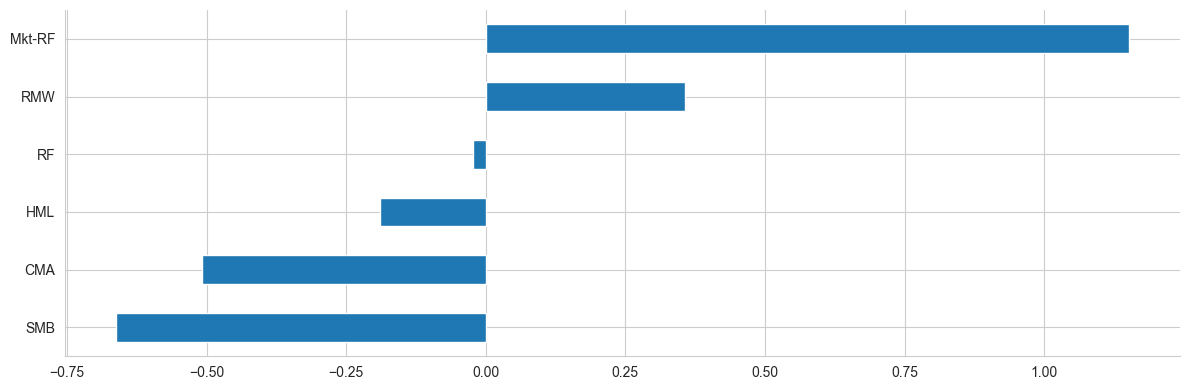

In [185]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [186]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.257960
SMB      -0.140645
HML      -0.042817
RMW       0.070730
CMA      -0.120705
RF       -0.055521
dtype: float64

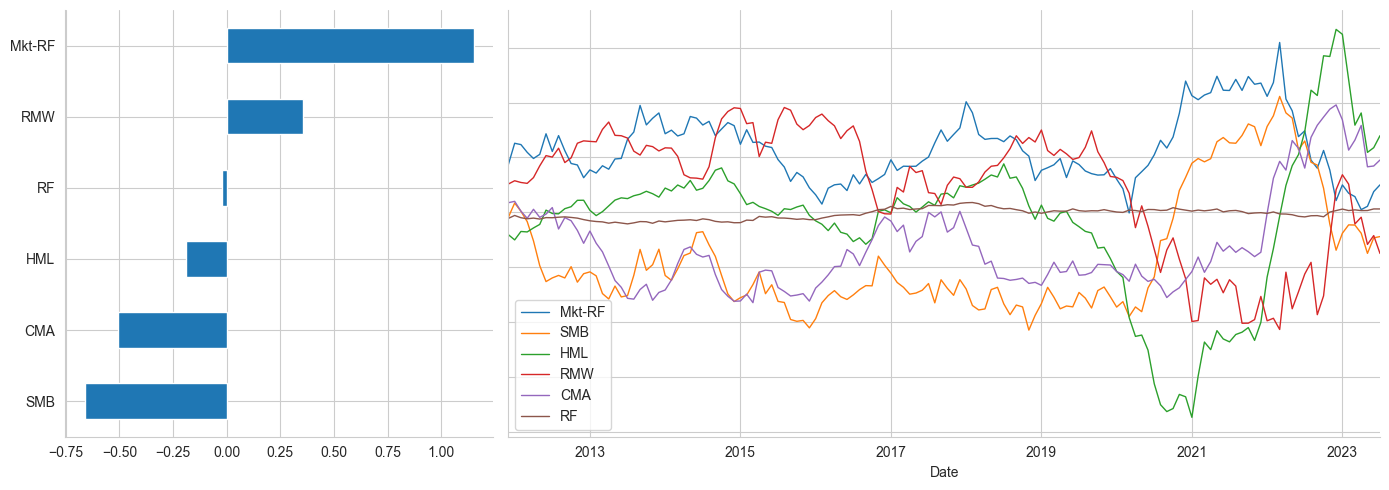

In [187]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

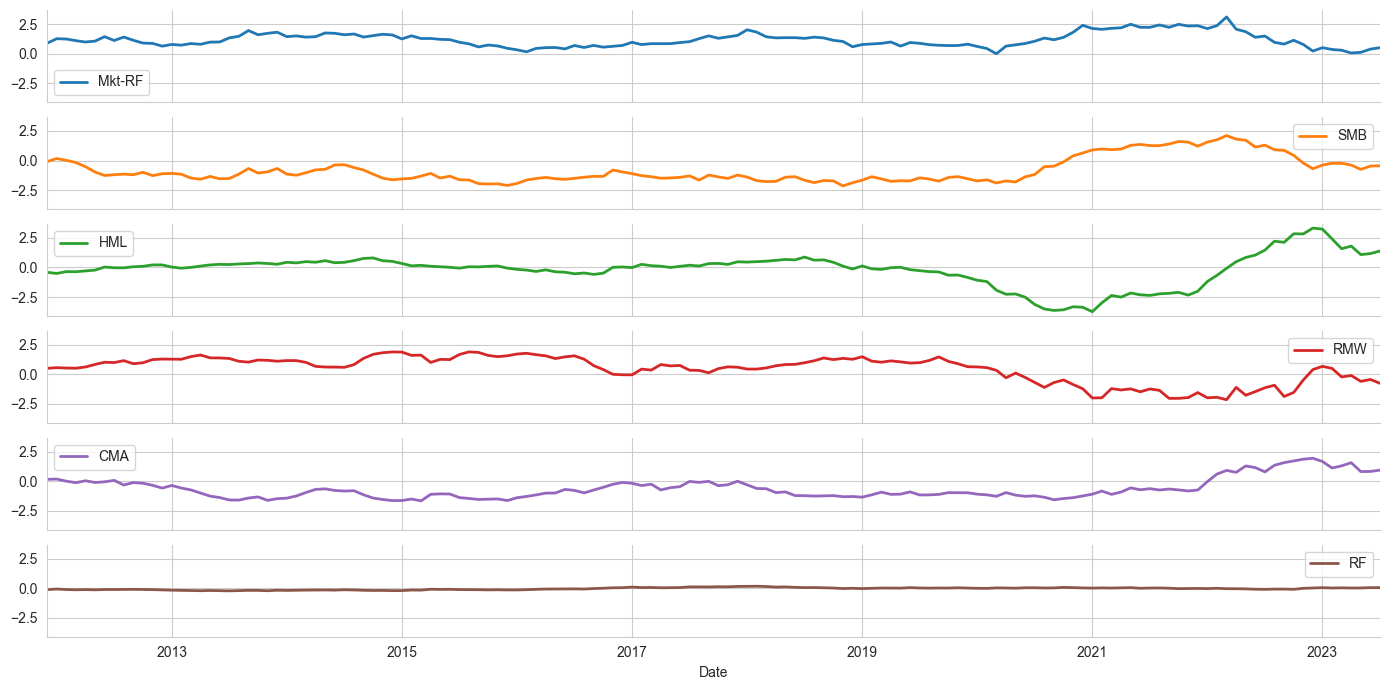

In [188]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

In [170]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.7093
No. Factors:                          6   J-statistic:                    9.8738
No. Observations:                   163   P-value                         0.5418
Date:                  Tue, Sep 26 2023   Distribution:                 chi2(11)
Time:                          12:27:29                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1526     0.3589     3.2113     0.0013      0.4491      1.8561
SMB           -0.6625     0.4440    

In [171]:
print(res.full_summary)


                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.7093
No. Factors:                          6   J-statistic:                    9.8738
No. Observations:                   163   P-value                         0.5418
Date:                  Tue, Sep 26 2023   Distribution:                 chi2(11)
Time:                          12:27:29                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.1526     0.3589     3.2113     0.0013      0.4491      1.8561
SMB           -0.6625     0.4440    

In [172]:
lambdas.mean()


Mkt-RF    1.152611
SMB      -0.662540
HML      -0.188947
RMW       0.356616
CMA      -0.507319
RF       -0.023303
dtype: float64

In [ ]:
# Para nuestro portafolio

In [225]:
excess_returns

,GS.N,NKE.N,CSCO.OQ,JPM.N,DIS.N,INTC.OQ,MRK.N,CVX.N,AXP.N,VZ.N,...,PG.N,IBM.N,MMM.N,AAPL.OQ,WMT.N,CAT.N,AMGN.OQ,V.N,TRV.N,BA.N
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,-0.126886,-0.035746,-0.063370,-0.066593,-0.087434,-0.050262,0.043904,-0.065344,-0.068919,-0.103993,...,0.022312,-0.067221,-0.026724,-0.093074,-0.000374,-0.080066,0.033206,-0.064097,0.016115,0.112906
2010-02,0.052268,0.058639,0.079529,0.074933,0.055616,0.064585,-0.034642,0.012023,0.013975,-0.016796,...,0.027719,0.042736,0.002297,0.063034,0.011907,0.088080,-0.032499,0.040348,0.037192,0.048187
2010-03,0.0774,0.077662,0.057540,0.054136,0.101074,0.070904,0.012914,0.037670,0.071670,0.059753,...,-0.010158,-0.001465,0.031785,0.128133,0.023528,0.086823,0.044151,0.055249,0.021461,0.129431
2010-04,-0.171385,0.022263,0.023620,-0.058601,0.043811,0.015284,-0.073843,0.061373,0.101353,-0.065551,...,-0.020101,-0.004169,0.049237,0.095692,-0.045702,0.076281,-0.050989,-0.018827,-0.071158,-0.012482
2010-05,-0.014083,-0.057618,-0.160443,-0.083061,-0.107430,-0.066674,-0.049289,-0.098340,-0.155623,-0.058583,...,-0.027364,-0.034189,-0.115217,-0.025282,-0.063573,-0.123899,-0.112343,-0.227869,-0.035348,-0.125031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,-0.416857,-0.325297,-0.283395,-0.416857,-0.354793,-0.089615,-0.351788,-0.345243,-0.413355,-0.357941,...,-0.282197,-0.346251,-0.384713,-0.247879,-0.319139,-0.405739,-0.317367,-0.335212,-0.416857,-0.307425
2023-04,-0.301284,-0.317273,-0.416857,-0.283119,-0.326607,-0.400536,-0.268101,-0.317321,-0.368411,-0.335152,...,-0.293358,-0.386354,-0.339495,-0.321425,-0.326408,-0.389432,-0.358349,-0.318264,-0.294788,-0.376957
2023-05,-0.410889,-0.416857,-0.310052,-0.378471,-0.416857,-0.343847,-0.404810,-0.416857,-0.377381,-0.416857,...,-0.416857,-0.329295,-0.416857,-0.314963,-0.383752,-0.416857,-0.416857,-0.409634,-0.416857,-0.365237


In [231]:
for i in excess_returns.columns:
    print(i)

GS.N
NKE.N
CSCO.OQ
JPM.N
DIS.N
INTC.OQ
MRK.N
CVX.N
AXP.N
VZ.N
HD.N
WBA.OQ
MCD.N
UNH.N
KO.N
JNJ.N
MSFT.OQ
HON.OQ
CRM.N
PG.N
IBM.N
MMM.N
AAPL.OQ
WMT.N
CAT.N
AMGN.OQ
V.N
TRV.N
BA.N


In [267]:
const = dji['Instrument'].tolist()
const_limp = [i for i in const if i != '']
const_limp

['GS.N',
 'NKE.N',
 'CSCO.OQ',
 'JPM.N',
 'DIS.N',
 'INTC.OQ',
 'DOW.N',
 'MRK.N',
 'CVX.N',
 'AXP.N',
 'VZ.N',
 'HD.N',
 'WBA.OQ',
 'MCD.N',
 'UNH.N',
 'KO.N',
 'JNJ.N',
 'MSFT.OQ',
 'HON.OQ',
 'CRM.N',
 'PG.N',
 'IBM.N',
 'MMM.N',
 'AAPL.OQ',
 'WMT.N',
 'CAT.N',
 'AMGN.OQ',
 'V.N',
 'TRV.N',
 'BA.N']

In [268]:
betas = []
for i in excess_returns.columns:
    step1 = OLS(endog=excess_returns.loc[:,i].astype(float), 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))
betas

[Mkt-RF    0.013113
 SMB      -0.001984
 HML       0.009876
 RMW      -0.005034
 CMA      -0.006435
 RF       -0.965076
 dtype: float64,
 Mkt-RF    0.009280
 SMB       0.001344
 HML      -0.003629
 RMW       0.006647
 CMA       0.001571
 RF       -0.991620
 dtype: float64,
 Mkt-RF    0.011166
 SMB      -0.003954
 HML       0.001125
 RMW      -0.000539
 CMA      -0.000926
 RF       -0.949204
 dtype: float64,
 Mkt-RF    0.011817
 SMB      -0.003101
 HML       0.012960
 RMW      -0.008041
 CMA      -0.006255
 RF       -0.897117
 dtype: float64,
 Mkt-RF    0.011874
 SMB      -0.000846
 HML       0.002579
 RMW      -0.004519
 CMA      -0.002203
 RF       -1.004415
 dtype: float64,
 Mkt-RF    0.009204
 SMB      -0.001218
 HML      -0.000923
 RMW       0.000030
 CMA       0.002911
 RF       -0.941921
 dtype: float64,
 Mkt-RF    0.005483
 SMB      -0.004566
 HML      -0.003312
 RMW      -0.002590
 CMA       0.010952
 RF       -0.955638
 dtype: float64,
 Mkt-RF    0.010413
 SMB      -0.000460
 

In [269]:
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=excess_returns.columns)
betas

,Mkt-RF,SMB,HML,RMW,CMA,RF
GS.N,0.013113,-0.001984,0.009876,-0.005034,-0.006435,-0.965076
NKE.N,0.009280,0.001344,-0.003629,0.006647,0.001571,-0.991620
CSCO.OQ,0.011166,-0.003954,0.001125,-0.000539,-0.000926,-0.949204
JPM.N,0.011817,-0.003101,0.012960,-0.008041,-0.006255,-0.897117
DIS.N,0.011874,-0.000846,0.002579,-0.004519,-0.002203,-1.004415
INTC.OQ,0.009204,-0.001218,-0.000923,0.000030,0.002911,-0.941921
MRK.N,0.005483,-0.004566,-0.003312,-0.002590,0.010952,-0.955638
CVX.N,0.010413,-0.000460,0.006526,-0.001182,0.006201,-0.985085
AXP.N,0.010198,0.000927,0.006684,-0.001341,-0.004379,-0.955071
VZ.N,0.005486,-0.004186,-0.001856,0.002025,0.008493,-1.004573


In [270]:
excess_returns.index

PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10',
             ...
             '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
             '2023-04', '2023-05', '2023-06', '2023-07'],
            dtype='period[M]', name='Date', length=163)

In [271]:
for period in betas.index:
    print(period)

GS.N
NKE.N
CSCO.OQ
JPM.N
DIS.N
INTC.OQ
MRK.N
CVX.N
AXP.N
VZ.N
HD.N
WBA.OQ
MCD.N
UNH.N
KO.N
JNJ.N
MSFT.OQ
HON.OQ
CRM.N
PG.N
IBM.N
MMM.N
AAPL.OQ
WMT.N
CAT.N
AMGN.OQ
V.N
TRV.N
BA.N


In [280]:
lambdas = []
for period in excess_returns.index:
    step2 = OLS(endog=excess_returns.loc[period, betas.index].astype(float), 
                exog=betas).fit()
    lambdas.append(step2.params)

In [281]:
lambdas

[Mkt-RF   -10.869142
 SMB        5.966036
 HML        0.681448
 RMW       -0.097922
 CMA        2.609086
 RF        -0.065853
 dtype: float64,
 Mkt-RF    6.450363
 SMB       2.778453
 HML      -0.161212
 RMW       2.092124
 CMA      -2.667784
 RF        0.017819
 dtype: float64,
 Mkt-RF    13.905920
 SMB        0.649858
 HML       -2.082275
 RMW        1.956445
 CMA       -0.243628
 RF         0.074206
 dtype: float64,
 Mkt-RF    9.794812
 SMB       6.260657
 HML      -5.606975
 RMW       5.121343
 CMA      -4.346755
 RF        0.071196
 dtype: float64,
 Mkt-RF   -13.259208
 SMB        5.659354
 HML       -0.256777
 RMW       -1.245414
 CMA       -2.835353
 RF        -0.051668
 dtype: float64,
 Mkt-RF   -16.841695
 SMB        4.297397
 HML       -1.121325
 RMW       -3.023882
 CMA       -3.128414
 RF        -0.115581
 dtype: float64,
 Mkt-RF    5.029054
 SMB       2.004882
 HML       2.057151
 RMW      -0.798479
 CMA      -1.211324
 RF       -0.021497
 dtype: float64,
 Mkt-RF   -23.149

In [282]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())
lambdas

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2010-01,-10.869142,5.966036,0.681448,-0.097922,2.609086,-0.065853
2010-02,6.450363,2.778453,-0.161212,2.092124,-2.667784,0.017819
2010-03,13.905920,0.649858,-2.082275,1.956445,-0.243628,0.074206
2010-04,9.794812,6.260657,-5.606975,5.121343,-4.346755,0.071196
2010-05,-13.259208,5.659354,-0.256777,-1.245414,-2.835353,-0.051668
...,...,...,...,...,...,...
2023-03,4.214903,-7.592882,-13.950363,0.201003,-5.880277,0.363331
2023-04,-8.437163,-2.879082,1.816104,-0.426172,0.066074,0.264226
2023-05,-0.636061,-1.128997,-7.571779,-2.286230,-6.271573,0.365921


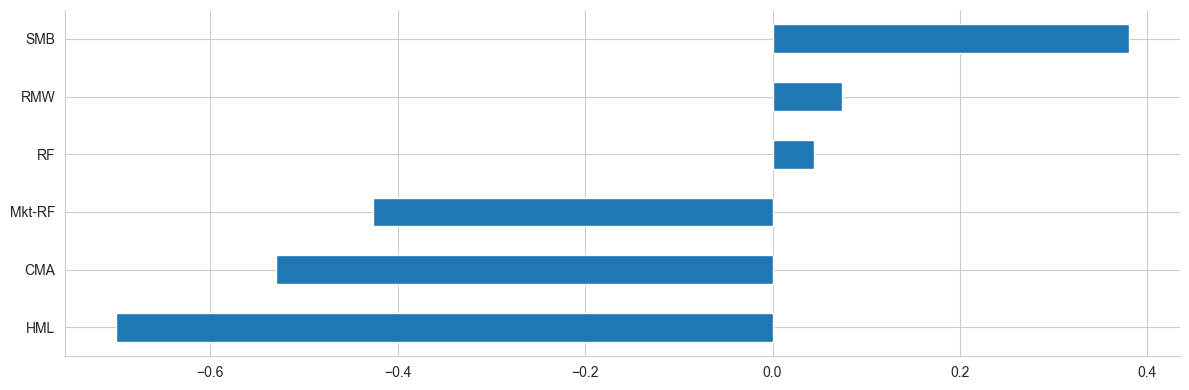

In [283]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [284]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF   -0.054820
SMB       0.076258
HML      -0.155374
RMW       0.020358
CMA      -0.160833
RF        0.376196
dtype: float64

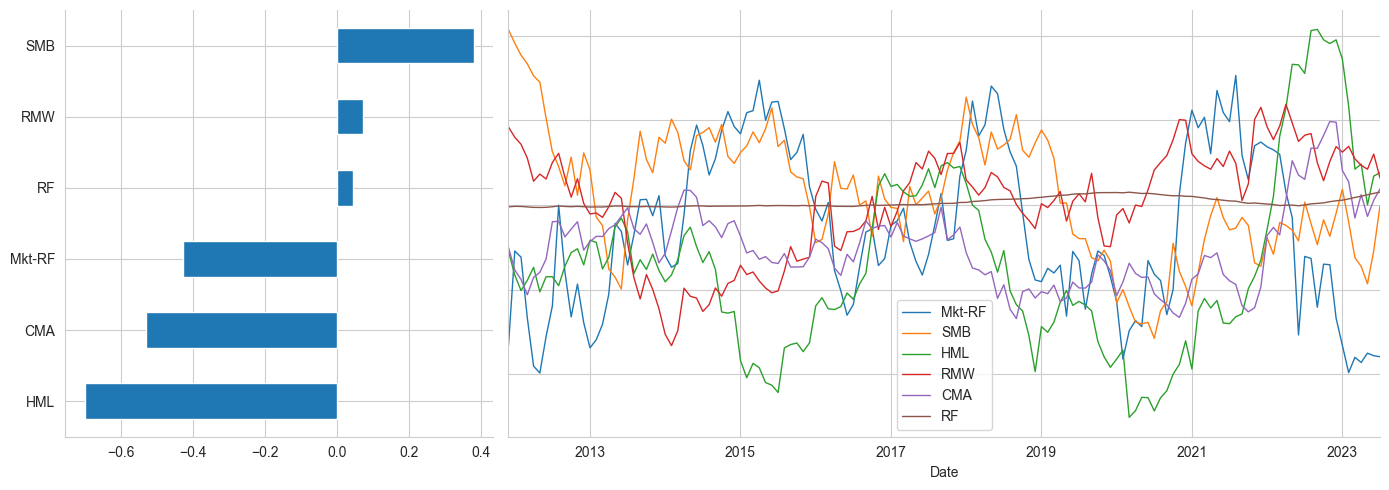

In [285]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

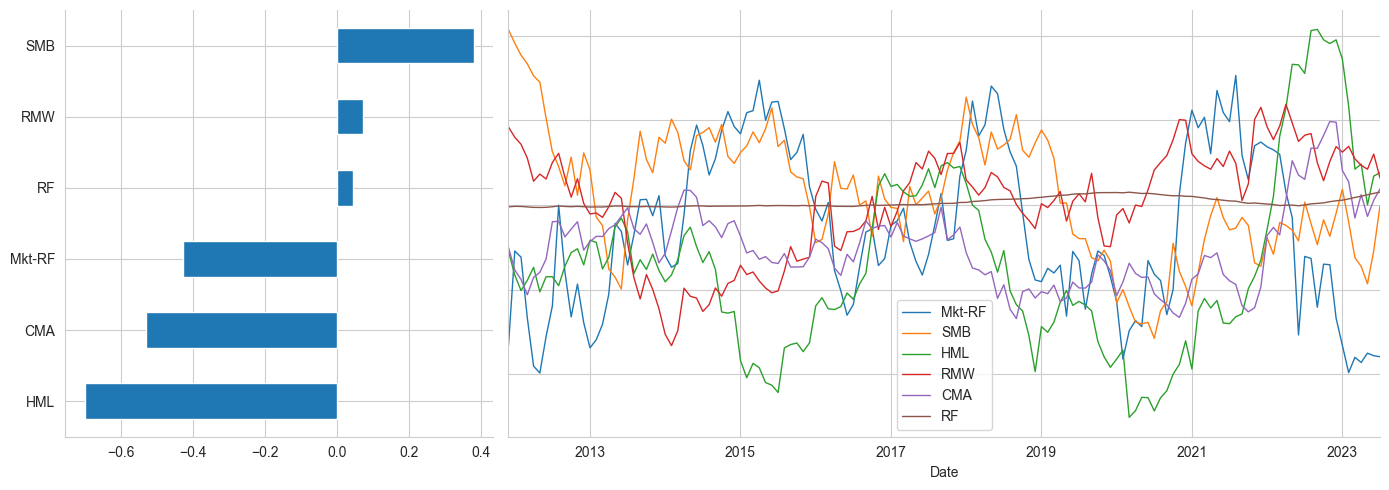

In [286]:
window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()

In [287]:
mod = LinearFactorModel(portfolios=excess_returns, 
                        factors=ff_factor_data)
res = mod.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 29   R-squared:                      0.8396
No. Factors:                          6   J-statistic:                    41.517
No. Observations:                   163   P-value                         0.0103
Date:                  Tue, Sep 26 2023   Distribution:                 chi2(23)
Time:                          18:01:52                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF        -0.4268     0.7825    -0.5455     0.5854     -1.9604      1.1068
SMB            0.3807     0.5643    

In [288]:
print(res.full_summary)


                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 29   R-squared:                      0.8396
No. Factors:                          6   J-statistic:                    41.517
No. Observations:                   163   P-value                         0.0103
Date:                  Tue, Sep 26 2023   Distribution:                 chi2(23)
Time:                          18:01:52                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF        -0.4268     0.7825    -0.5455     0.5854     -1.9604      1.1068
SMB            0.3807     0.5643    